In [39]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import Model
from keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential,load_model
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import matplotlib.pyplot as plt
import os
import cv2
import csv
from PIL import Image
from keras.optimizers import RMSprop
from sklearn.metrics import classification_report
import imghdr
import seaborn as sns


In [22]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        print("Found a GPU with the name:", gpu)

Found a GPU with the name: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
# train_df = pd.read_csv(os.path.join(os.getcwd(),r"data\traffic-lights.v3i.tensorflow (2)\train\_annotations.csv"))

# valid_df = pd.read_csv(os.path.join(os.getcwd(),r"data\traffic-lights.v3i.tensorflow (2)\valid\_annotations.csv"))

# test_df = pd.read_csv(os.path.join(os.getcwd(),r"data\traffic-lights.v3i.tensorflow (2)\test\_annotations.csv"))

In [23]:
def crop_direcory(dir_path_end, array,dir_path_start, csv_file_path):
    fields = ["filename","width","height","class"]
    
    i=0
    with open(csv_file_path, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fields,lineterminator='\n')
        writer.writeheader()
    
        for file in array:
            filename = file[0]
            category = file[3]
            xmin = file[4]
            ymin = file[5]
            xmax = file[6]
            ymax = file[7]
            image_path = os.path.join(dir_path_start, str(filename))
            image = Image.open(image_path)
            crop_image = image.crop((xmin,ymin,xmax,ymax))
            width, height = crop_image.size
            if width > 30 and height > 30:
                i +=1
                crop_image = crop_image.resize((64,64))
                crop_image.save(os.path.join(dir_path_end, (str(i)+".jpg")))
                new_row = {'filename': (str(i)+".jpg"), 'width': width, 'height': height, 'class': category}
                writer.writerow(new_row)

def find_row_sum(array):
    sum_width = 0
    sum_height = 0
    i=1

    for file in array:
        width = file[1]
        height = file[2]
        sum_width += width
        sum_height += height
        i += 1
    
    sum_width = sum_width/ i
    sum_height = sum_height/i
    
    return sum_width , sum_height

def change_images_by_color(csv_file_path, image_dir, num):
    
    for color in ["red", "yellow", "green"]:
        data = pd.read_csv(csv_file_path)
        i=0
        j=0
        number_of_color = 0
        
        fields = ["filename","width","height","class"]
        array = data.to_numpy()
        number_of_color = data['class'].value_counts()[color] // num
        print(number_of_color)

        
        with open(csv_file_path, 'w') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fields,lineterminator='\n')
            writer.writeheader()

            for file in array:
                i +=1
                filename = file[0]
                width = file[1]
                height = file[2]
                category = file[3]
                image_path = os.path.join(image_dir, str(filename))
                
                if j < number_of_color and category == color:   
                    j +=1      
                    changed_image = Image.open(image_path).convert("L")
                    changed_image.save(image_path)
                    
                    new_row = {'filename': (str(i)+".jpg"), 'width': width, 'height': height, 'class': "not a traffic light"}
                    writer.writerow(new_row)

                else:
                    new_row = {'filename': (str(i)+".jpg"), 'width': width, 'height': height, 'class': category}
                    writer.writerow(new_row)
            csvfile.close()


def change_filenames_in_csv_file(array, csv_file_path):

    fields = ["filename","width","height","class"]

    i=0
    with open(csv_file_path, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fields,lineterminator='\n')

        writer.writeheader()

        for file in array:
            i +=1
            filename = file[0]
            width = file[1]
            height = file[2]
            category = file[3]
        
            if category in ["red", "yellow", "green"]:
                
                new_row = {'filename': (str(i)+".jpg"), 'width': width, 'height': height, 'class': category}
                writer.writerow(new_row)
            else:
                                
                new_row = {'filename': (str(i)+".jpg"), 'width': width, 'height': height, 'class': "not a traffic light"}
                writer.writerow(new_row)

In [24]:
# image_dir = os.path.join(os.getcwd(),r"data\data_crop\train")
# array = train_df.to_numpy()
# csv_file_path = os.path.join(os.getcwd(),r"data\data_crop\train\_annotations.csv")
# dir_path_start = os.path.join(os.getcwd(),r"data\traffic-lights.v3i.tensorflow (2)\train")

# crop_direcory(image_dir, array,dir_path_start, csv_file_path)


In [25]:
crop_train_df = pd.read_csv(os.path.join(os.getcwd(),r"data\data_crop\train\_annotations.csv"))
# train_df["class"]=train_df["class"].replace({"red": 0, "green": 1 , "yellow": 2})  

crop_valid_df = pd.read_csv(os.path.join(os.getcwd(),r"data\data_crop\valid\_annotations.csv"))
# valid_df["class"]=valid_df["class"].replace({"red": 0, "green": 1 , "yellow": 2})

crop_test_df = pd.read_csv(os.path.join(os.getcwd(),r"data\data_crop\test\_annotations.csv"))
# test_df["class"]=test_df["class"].replace({"red": 0, "green": 1 , "yellow": 2})

In [26]:
crop_train_df.head()

,filename,width,height,class
0,1.jpg,338,244,green
1,2.jpg,135,312,green
2,3.jpg,178,314,green
3,4.jpg,168,97,green
4,5.jpg,110,170,green


In [27]:
crop_train_df.isnull().sum()

filename    0
width       0
height      0
class       0
dtype: int64

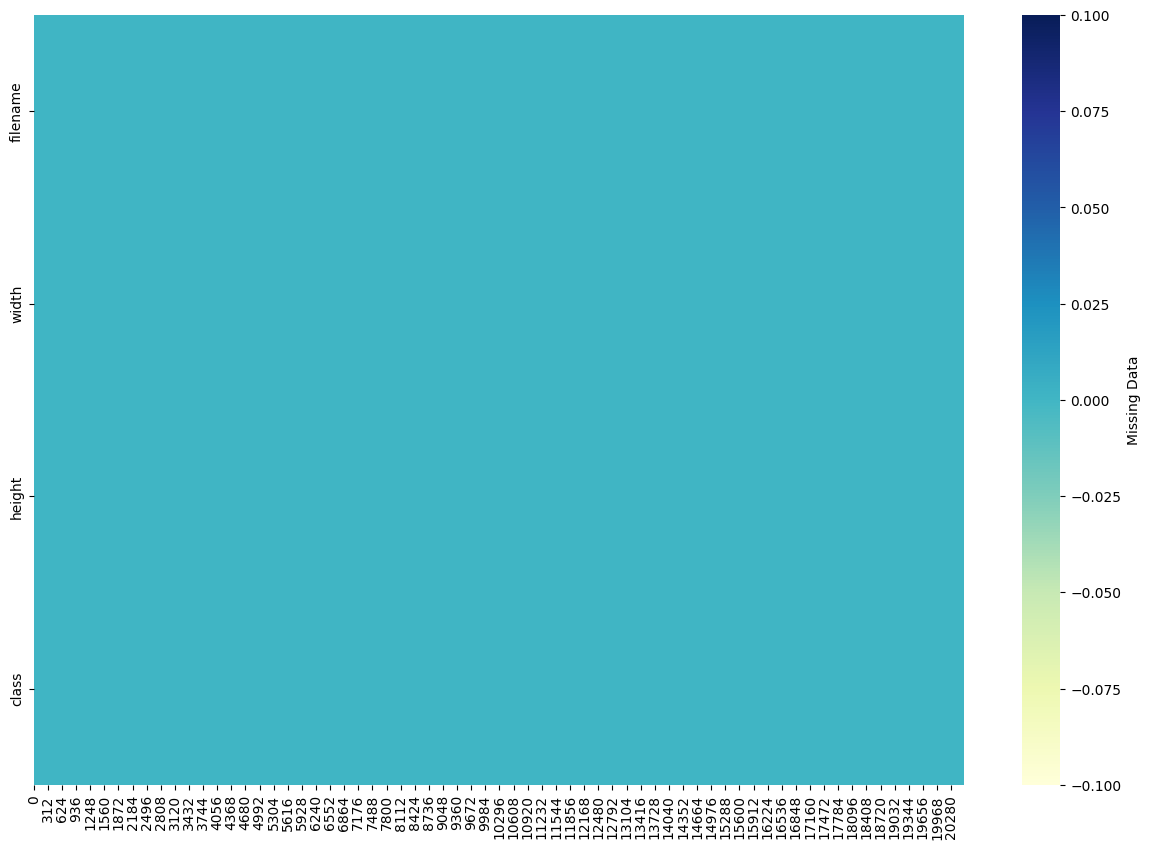

In [28]:
plt.figure(figsize = (15,10))
sns.heatmap(crop_train_df.isna().transpose(), cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

plt.show()

<Axes: xlabel='class', ylabel='count'>

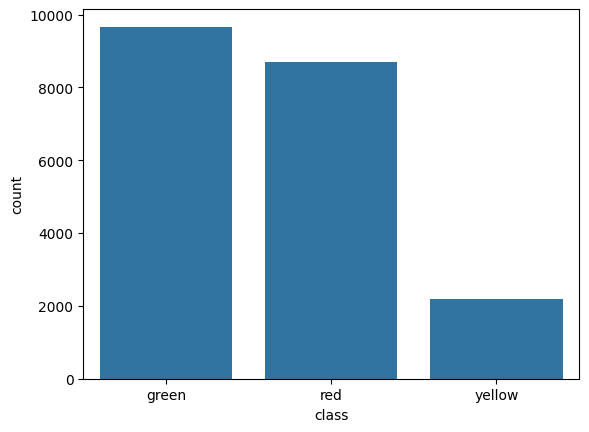

In [29]:
sns.countplot(x=crop_train_df["class"])

In [30]:
IMAGE_CHANNELS = 3
batch_size=64
IMAGE_SIZE = 64
num_classes=3
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)


In [31]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


training_set = train_datagen.flow_from_dataframe(
    crop_train_df,
    r"F:\cnn project\data\data_crop\train\\",
    x_col='filename',
    y_col='class',
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    class_mode='categorical',
    batch_size=batch_size
)


valid_set = valid_datagen.flow_from_dataframe(
    crop_valid_df,
    r"F:\cnn project\data\data_crop\valid\\",
    x_col='filename',
    y_col='class',
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    class_mode='categorical',
    batch_size=batch_size
)


test_set = test_datagen.flow_from_dataframe(
    crop_test_df,
    r"F:\cnn project\data\data_crop\test\\",
    x_col='filename',
    y_col='class',
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    class_mode='categorical',
    batch_size=batch_size
)

Found 20559 validated image filenames belonging to 3 classes.
Found 2166 validated image filenames belonging to 3 classes.
Found 833 validated image filenames belonging to 3 classes.


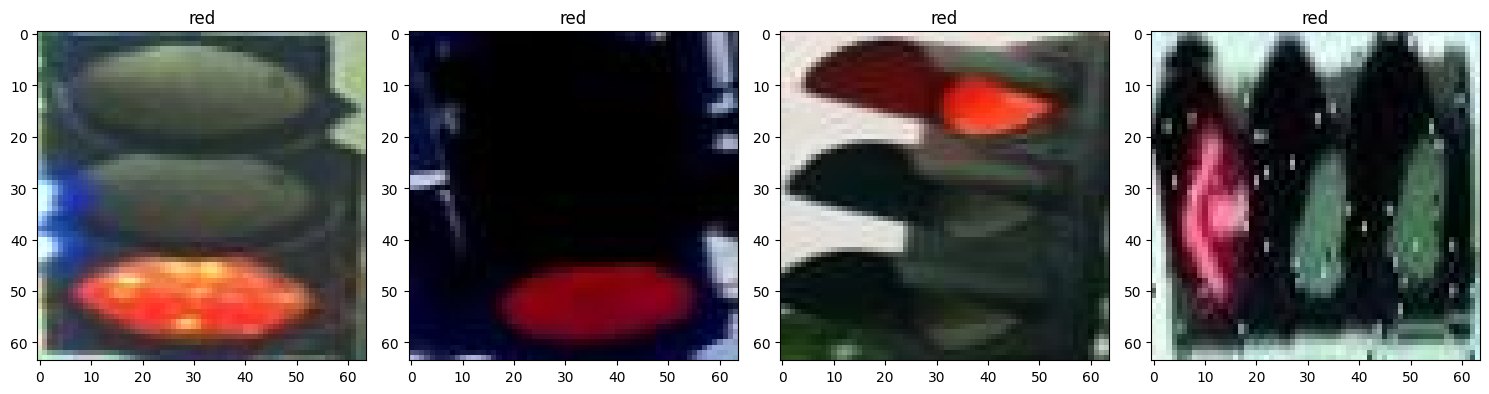

In [32]:
images, labels = training_set.next()

# Get class indices to class names mapping
class_indices = training_set.class_indices
class_names = {v: k for k, v in class_indices.items()}

# Plot the images along with their labels
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i in range(4):
    axes[i].imshow(images[i]) 
    label_index = int(labels[i].argmax())  # Convert one-hot encoded label to class index
    class_name = class_names[label_index]
    axes[i].set_title(f"{class_name}")

plt.tight_layout()
plt.show()

In [33]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape = input_shape),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,activation='relu'),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(num_classes,activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 dense_7 (Dense)             (None, 31, 31, 32)        1056      
                                                                 
 dropout_7 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 32)        9248      
                                                      

In [34]:
# Train the model
history = model.fit(
    training_set,
    validation_data=valid_set,
    epochs=5,  # adjust based on your needs 20
)


model.save('best_model.h5')  # creates a HDF5 file 'my_model.h5'

Epoch 1/5
322/322 [==============================] - 13s 36ms/step - loss: 0.5475 - accuracy: 0.7817 - val_loss: 0.2533 - val_accuracy: 0.9400
Epoch 2/5
322/322 [==============================] - 11s 34ms/step - loss: 0.2231 - accuracy: 0.9250 - val_loss: 0.1413 - val_accuracy: 0.9686
Epoch 3/5
322/322 [==============================] - 11s 34ms/step - loss: 0.1731 - accuracy: 0.9431 - val_loss: 0.1265 - val_accuracy: 0.9705
Epoch 4/5
322/322 [==============================] - 11s 35ms/step - loss: 0.1462 - accuracy: 0.9524 - val_loss: 0.1115 - val_accuracy: 0.9723
Epoch 5/5
322/322 [==============================] - 12s 36ms/step - loss: 0.1275 - accuracy: 0.9572 - val_loss: 0.1007 - val_accuracy: 0.9728


In [35]:
model_path = r"F:\cnn project\model1.h5"
model.load_weights(model_path)
preds = model.predict(test_set)  # Running model on the validation dataset
val_loss, val_acc = model.evaluate(test_set) # Obtaining Loss and Accuracy on the val dataset

print('\nValidation Loss: ', val_loss)
print('\nValidation Accuracy: ', np.round(val_acc * 100), '%')

14/14 [==============================] - 0s 27ms/step - loss: 0.1324 - accuracy: 0.9724

Validation Loss:  0.13244028389453888

Validation Accuracy:  97.0 %


In [36]:
from sklearn.metrics import confusion_matrix
crop_test1_df = pd.read_csv(os.path.join(os.getcwd(),r"data\data_crop\test\_annotations.csv"))

dir_img_path = r"F:\cnn project\data\data_crop\test"
images_path = []
predicted_classes = []
true_classes = []
array = crop_test1_df.to_numpy()


for data in array:
    path = data[0]
    cls = data[3]
    if(path != " "):
        image_path = os.path.join(dir_img_path, str(path))
        
        if os.path.exists(image_path):
            true_classes.append(str(cls))
            
            original_image = Image.open(image_path)

            preprocessed_image = np.array(original_image) / 255.0

            preds = model.predict(np.expand_dims(preprocessed_image, axis=0))
            labels = ['green', 'red',"yellow"]

            preds_class = np.argmax(preds)
            preds_label = labels[preds_class]
            predicted_classes.append(preds_label)
    

# Get class labels
class_labels = ['green', 'red',"yellow"]

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

print(cm)

1/1 [==============================] - 0s 23ms/step
[[400   5   3]
 [  2 336  11]
 [  0   2  74]]


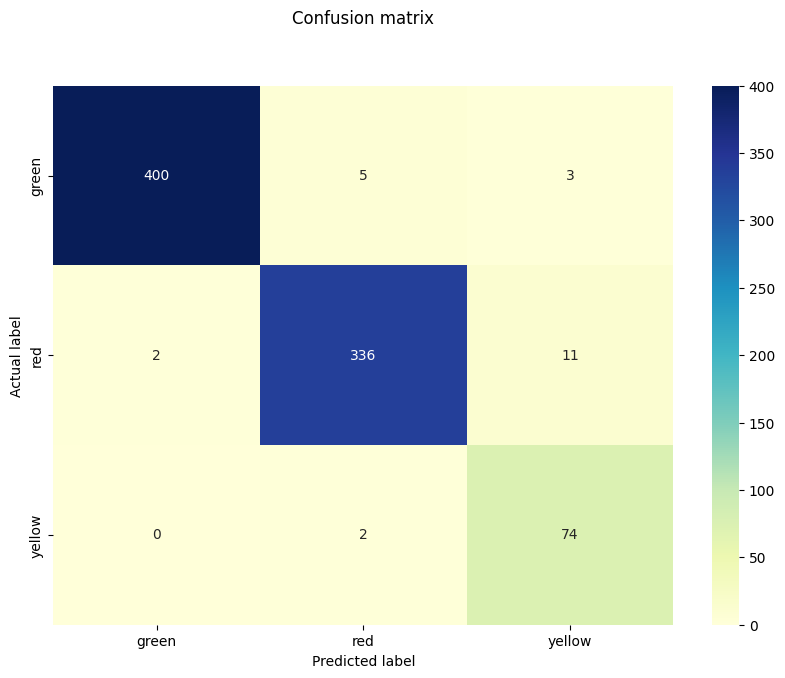

In [37]:
plt.figure(figsize=(10, 7))
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu", fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [40]:
print(classification_report(true_classes, predicted_classes, target_names=labels))

              precision    recall  f1-score   support

       green       1.00      0.98      0.99       408
         red       0.98      0.96      0.97       349
      yellow       0.84      0.97      0.90        76

    accuracy                           0.97       833
   macro avg       0.94      0.97      0.95       833
weighted avg       0.97      0.97      0.97       833



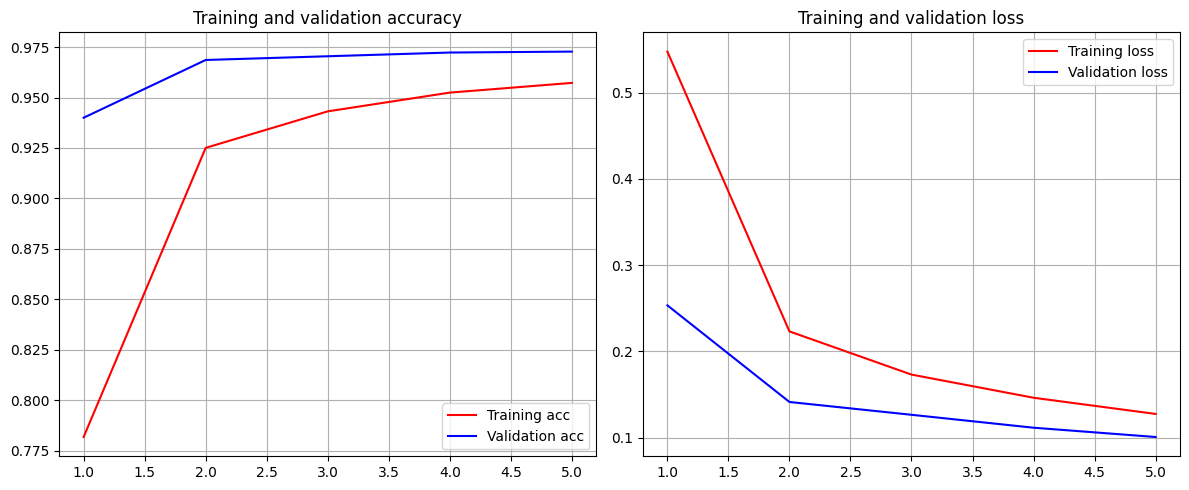

In [41]:
def visualize(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    axs[0].plot(epochs, acc, 'r', label='Training acc')
    axs[0].plot(epochs, val_acc, 'b', label='Validation acc')
    axs[0].set_title('Training and validation accuracy')
    axs[0].grid(True)
    axs[0].legend()
    
    axs[1].plot(epochs, loss, 'r', label='Training loss')
    axs[1].plot(epochs, val_loss, 'b', label='Validation loss')
    axs[1].set_title('Training and validation loss')
    axs[1].grid(True)
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()
    
visualize(history)


1/1 [==============================] - 0s 35ms/step
[[3.390743e-10 3.111930e-10 1.000000e+00]]

Predicted Class: yellow

Confidence Score: 1.0


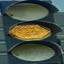

In [ ]:
# original_image = Image.open(
#     r"F:\cnn project\data\data_crop\test\221.jpg")


# # Manually preprocessing image
# preprocessed_image = np.array(original_image) / 255.0

# preds = model.predict(np.expand_dims(preprocessed_image, axis=0))
# labels = ['green', 'red',"yellow"]


# print(preds)
# preds_class = np.argmax(preds)

# preds_label = labels[preds_class]


# print(f'\nPredicted Class: {preds_label}')

# print(f'\nConfidence Score: {preds[0][preds_class]}')

# original_image

1/1 [==============================] - 0s 21ms/step
green
1/1 [==============================] - 0s 20ms/step
green
1/1 [==============================] - 0s 27ms/step
red
1/1 [==============================] - 0s 19ms/step
red
1/1 [==============================] - 0s 21ms/step
green
1/1 [==============================] - 0s 22ms/step
green
1/1 [==============================] - 0s 21ms/step
red
1/1 [==============================] - 0s 21ms/step
green
1/1 [==============================] - 0s 21ms/step
green
1/1 [==============================] - 0s 21ms/step
red
1/1 [==============================] - 0s 20ms/step
green
1/1 [==============================] - 0s 21ms/step
red
1/1 [==============================] - 0s 22ms/step
green
1/1 [==============================] - 0s 20ms/step
red
1/1 [==============================] - 0s 21ms/step
green
1/1 [==============================] - 0s 29ms/step
green
1/1 [==============================] - 0s 22ms/step
red
1/1 [=======================

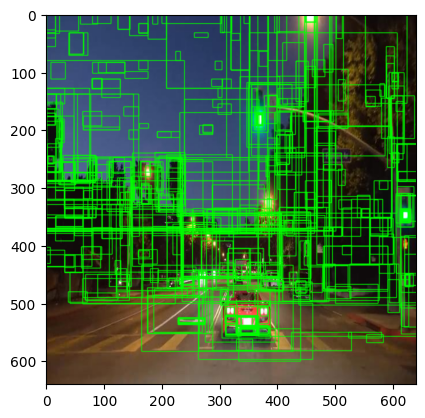

In [ ]:
model_path = r"F:\cnn project\model1.h5"
model.load_weights(model_path)

bounding_boxes = []
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
z=0
labels = ['green', 'not a traffic light', 'red',"yellow"]

img = cv2.imread(r"F:\cnn project\data\traffic-lights.v3i.tensorflow (2)\test\Los-Angeles-4K-California-Glow-Scenic-Drive_mp4-755_jpg.rf.91438add5bc4f45328dbdbb6873aa88b.jpg")
imout = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ss.setBaseImage(imout)
ss.switchToSelectiveSearchQuality()
ssresults = ss.process()

# imout = img.copy()
for e,result in enumerate(ssresults):
    if e < 2000:
        x,y,w,h = result
        timage = imout[y:y+h,x:x+w]
        resized = cv2.resize(timage, (64,64),  interpolation = cv2.INTER_AREA)
        img = np.expand_dims(resized, axis=0)
        
        preprocessed_image = np.array(resized) / 255.0

        preds = model.predict(np.expand_dims(preprocessed_image, axis=0))
        out= model.predict(img)
        
        preds_class = np.argmax(preds)  
        # print(f'\nConfidence Score: {preds[0][preds_class]}')
        preds_label = labels[preds_class]
        if float(preds[0][preds_class]) > 0.999 and (preds_label in ["red" ,"green", "yellow"]):
            bounding_boxes.append([x,y,x+w, y+h, preds_class, float(preds[0][preds_class])])
            print(preds_label)
            cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure()
plt.imshow(imout)
    

In [ ]:
class NMS:
    
    def __init__(self) -> None:
        self.conf = 0.9999313354492188
        self.iou_threshsold =0.4
    def are_close(self, box1, box2, threshold_distance):
        
        # Calculate the distance between the centers of two boxes
        center1 = ((box1[0] + box1[2]) / 2, (box1[1] + box1[3]) / 2)
        center2 = ((box2[0] + box2[2]) / 2, (box2[1] + box2[3]) / 2)
        distance = ((center1[0] - center2[0]) + (center1[1] - center2[1]))**0.5
        return distance < threshold_distance
    
    
    def merge_close_boxes(self, threshold_distance, bboxes_list):
        merged_boxes = []
        merged_indices = set()

        for i, box1 in enumerate(bboxes_list):
            if i in merged_indices:
                continue  # Skip if box is already merged
            merged_box = list(box1)  # Convert to list for easy modification
            for j, box2 in enumerate(bboxes_list[i+1:], start=i+1):
                if NMS.are_close(self, box1, box2, threshold_distance):
                    # Merge the coordinates of two close boxes
                    merged_box[0] = min(merged_box[0], box2[0])
                    merged_box[1] = min(merged_box[1], box2[1])
                    merged_box[2] = max(merged_box[2], box2[2])
                    merged_box[3] = max(merged_box[3], box2[3])
                    merged_indices.add(j)  # Mark box2 as merged
            merged_boxes.append(tuple(merged_box))

        return merged_boxes


    def IOU(self, bboxes1, bboxes2):
        bboxes1 = [int(i) for i in bboxes1]
        bboxes2= [int(i) for i in bboxes2]

        xA = max(bboxes1[0], bboxes2[0])
        yA = max(bboxes1[1], bboxes2[1])
        xB = min(bboxes1[2], bboxes2[2])
        yB = min(bboxes1[3], bboxes2[3])

        intersection_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)

        box1_area = (bboxes1[2] - bboxes1[0] + 1) * (bboxes1[3] - bboxes1[1] + 1)
        box2_area = (bboxes2[2] - bboxes2[0] + 1) * (bboxes2[3] - bboxes2[1] + 1)

        iou = intersection_area / float(box1_area + box2_area - intersection_area)

        return iou
    
        
    def draw_bounding_boxes(self, image, bounding_boxes):
        """
        Draw bounding boxes on an image.

        Args:
        - image: The input image.
        - bounding_boxes: A list of bounding box coordinates in the format (xmin, ymin, xmax, ymax).
        - color: The color of the bounding boxes (in BGR format, default is green).
        - thickness: The thickness of the bounding box lines.

        Returns:
        - annotated_image: The image with bounding boxes drawn.
        """
        color=(0, 255, 0)
        thickness=2
        annotated_image = image.copy()

        for bbox in bounding_boxes:
            xmin = bbox[0]
            ymin = bbox[1]
            xmax = bbox[2]
            ymax = bbox[3]
            # if ymax-ymin < 200:
            cv2.rectangle(annotated_image, (xmin, ymin), (xmax, ymax), color, thickness)

        return annotated_image
    def sum_bounding_boxes(self, box1, box2):
        """
        Sum the coordinates of two bounding boxes.

        Args:
        - box1: A tuple representing the first bounding box in the format (xmin, ymin, xmax, ymax).
        - box2: A tuple representing the second bounding box in the format (xmin, ymin, xmax, ymax).

        Returns:
        - sum_box: A tuple representing the sum of the coordinates of the two bounding boxes.
        """
        xmin = (box1[0] + box2[0]) // 2
        ymin = (box1[1] + box2[1]) // 2
        xmax = (box1[2] + box2[2]) // 2
        ymax = (box1[3] + box2[3]) // 2
        sum_box = (xmin, ymin, xmax, ymax)
        return sum_box


    def nms(self, image, bboxes_list):
        req_bboxes, final_boxes, sum_boxes = [], [],[]

        for coord in bboxes_list: 
            prob = float(coord[5])
            
            # Check if the bounding box size is larger than 40x40 pixels
            if prob > self.conf and (coord[2] - coord[0]) >= 40 and (coord[3] - coord[1]) >= 40:
                req_bboxes.append(coord)

        # sorting the bounding boxes based on probability score
        bboxes_sorted = sorted(req_bboxes, reverse=True, key=lambda x: x[4])

        # Keep track of the number of remaining boxes
        remaining_boxes = 0

        while len(bboxes_sorted) > 0 and remaining_boxes < 10:  # Adjust maximum number of boxes here
            # removing the best probability bounding box
            box = bboxes_sorted.pop(0)

            # Check if the box overlaps with existing final boxes
            overlaps = False
            for final_box in final_boxes:
                if self.IOU(box[0:4], final_box[0:4]) >= self.iou_threshsold:
                    overlaps = True
                    sum_boxes.append(self.sum_bounding_boxes(box[0:4], final_box[0:4]))
                    break

            if not overlaps:
                final_boxes.append(box)
                remaining_boxes += 1

        return NMS.merge_close_boxes(self, 10, final_boxes), NMS.merge_close_boxes(self, 10, sum_boxes)

In [ ]:
# print(bounding_boxes)

[[614, 337, 631, 358, 0, 1.0], [609, 310, 635, 368, 0, 0.9998999834060669], [603, 300, 633, 361, 0, 1.0], [613, 314, 640, 448, 0, 0.999870777130127], [362, 164, 375, 197, 0, 1.0], [360, 162, 379, 200, 0, 1.0], [355, 127, 392, 214, 0, 0.999983549118042], [360, 163, 378, 199, 0, 1.0], [615, 338, 629, 358, 0, 1.0], [611, 332, 637, 369, 0, 1.0], [357, 156, 384, 208, 0, 1.0], [357, 164, 378, 208, 0, 1.0], [361, 127, 375, 164, 0, 1.0], [367, 122, 401, 181, 0, 1.0], [350, 120, 442, 225, 0, 0.9999412298202515], [608, 332, 640, 553, 2, 0.9992974996566772], [290, 121, 427, 384, 0, 0.999707043170929], [416, 176, 452, 240, 0, 0.9997358918190002], [610, 300, 634, 370, 0, 1.0], [614, 305, 640, 480, 0, 1.0], [608, 272, 640, 314, 0, 0.9999982118606567], [616, 338, 628, 357, 0, 1.0], [616, 340, 628, 356, 0, 0.9999933242797852], [286, 112, 305, 125, 0, 1.0], [609, 311, 625, 367, 0, 0.9999723434448242], [366, 173, 373, 191, 2, 0.9999170303344727], [607, 298, 636, 368, 0, 1.0], [336, 0, 447, 219, 0, 0.999

In [ ]:
image = cv2.imread(r"F:\cnn project\data\traffic-lights.v3i.tensorflow (2)\test\Los-Angeles-4K-California-Glow-Scenic-Drive_mp4-755_jpg.rf.91438add5bc4f45328dbdbb6873aa88b.jpg")

data = bounding_boxes
obj = NMS()


# Apply NMS to limit the number of boxes to 4-5 and filter out small boxes
final_boxes, sum_boxes = obj.nms(image,data)
print(final_boxes)

# Display the number of remaining boxes after NMS
print("Number of boxes after NMS and size filtering:", len(final_boxes))
annotated_image = obj.draw_bounding_boxes(image, final_boxes)
test_image = obj.draw_bounding_boxes(image, sum_boxes)
# test_test_image = obj.draw_bounding_boxes(image, test_image)

cv2.imshow("Annotated Image", annotated_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.imshow("test Image", test_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
# Draw final bounding boxes after NMS

C:\Users\Ido\AppData\Local\Temp\ipykernel_18756\707731716.py:11: RuntimeWarning: invalid value encountered in scalar power
  distance = ((center1[0] - center2[0]) + (center1[1] - center2[1]))**0.5


[(336, 0, 447, 225, 0, 0.9999412298202515), (591, 299, 634, 550, 0, 0.9999972581863403), (576, 252, 640, 336, 0, 0.9999969005584717), (350, 75, 482, 268, 0, 0.9999890327453613)]
Number of boxes after NMS and size filtering: 4


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.utils import load_img
from keras.models import Sequential,load_model
import matplotlib.pyplot as plt
import os
from PIL import Image
 

class cnn_model():
    def __init__(self, model_path, image_path, labels):
        self.model_path = model_path
        self.image_path = image_path
        self.labels = labels
        
    def get_model_input_size(self):
        model = load_model(self.model_path)
        inputs = model.input.shape
        clean_outputs = tuple(inputs[1:3])  # We only need the first two dimensions
        return clean_outputs

    def resize_img(self):
        image = Image.open(self.image_path).convert('L')  # Convert image to grayscale
        size = cnn_model.get_model_input_size(self)
        resized = image.resize(size)  # Resize directly to the desired input size
        resized = np.expand_dims(resized, axis=-1)  # Add grayscale channel
        resized = np.tile(resized, (1, 1, 3))  # Convert to RGB by repeating grayscale channel
        resized = Image.fromarray(resized)
        resized.save(self.image_path)
        image.close()


    def model_evaluation(self):
        model = load_model(self.model_path)
        val_loss, val_acc = model.evaluate()
        
        return val_loss, val_acc



    def model_prediction(self):
        cnn_model.resize_img(self)
        img = Image.open(self.image_path)
        model = load_model(self.model_path)
        
        preprocessed_image = np.array(img) / 255.0

        preds = model.predict(np.expand_dims(preprocessed_image, axis=0))

        preds_class = np.argmax(preds)

        preds_label = self.labels[preds_class]
        Confidence = preds[0][preds_class]
        print(Confidence)
        print(preds_label)
        return Confidence, preds_label

    def get_labels(self):
        model = load_model(self.model_path)
        output = model.output.shape
        num_of_classes = output[1]
        
        
        
labels = ['green', 'not a traffic light', 'red',"yellow"]
test = cnn_model(r"F:\cnn project\model1.h5",r"F:\cnn project\data\data_crop\test\7.jpg",labels)
test.model_prediction()
test.get_model_input_size()



1/1 [==============================] - 7s 7s/step
0.730485
not a traffic light


(64, 64)